In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format','{:.2f}'.format)

In [3]:
df = pd.read_excel("./news/weekly_news_amg_prices.xlsx", index_col='Date')

In [4]:
df

,Description,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog
Date,,,,,,,
2018-03-27,Alphabet Inc's Google is launching the Google...,78.62,74.85,94.94,83.75,53.15,50.26
2018-04-04,There are no specific U.S. policy changes at t...,67.91,70.53,87.85,86.43,49.67,51.26
2018-04-12,Janet Yellen cashed in with her first paid vis...,71.97,72.43,92.43,87.60,51.25,51.63
2018-04-22,Investors are optimistic that a pickup in corp...,78.06,76.37,95.91,88.93,54.10,53.65
2018-04-30,A gauge of global equity markets declined on M...,79.12,78.31,96.33,87.54,51.50,50.87
...,...,...,...,...,...,...,...
2020-06-14,With a full three months of responding to a gl...,130.06,127.25,190.54,181.58,71.42,70.66
2020-06-23,Stock market gains have further to run and inv...,136.30,138.22,202.09,195.28,72.78,73.22
2020-06-30,Alphabet Inc's Google said on Wednesday it wil...,134.25,137.94,197.88,196.83,69.52,70.68


<Axes: xlabel='Date'>

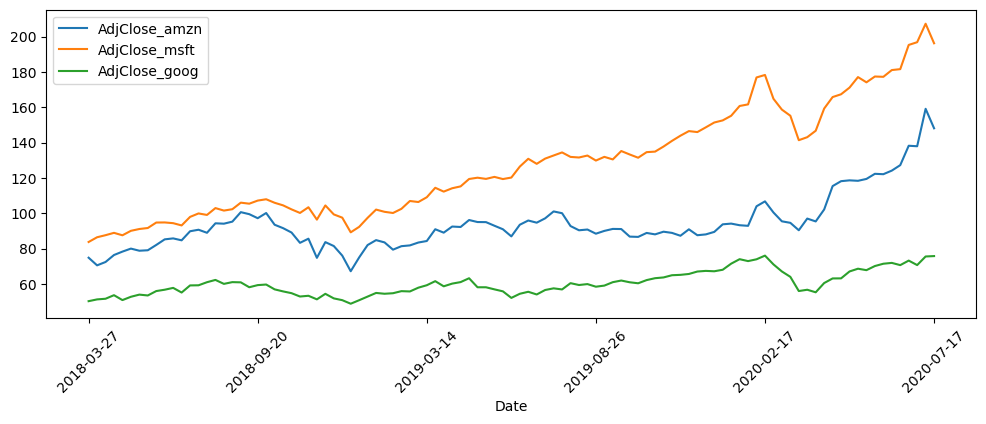

In [5]:
df[['AdjClose_amzn', 'AdjClose_msft', 'AdjClose_goog']].plot(figsize=(12,4), rot=45)

In [6]:
amzn_gain = df['AdjClose_amzn'].iloc[-1]/df['AdjClose_amzn'].iloc[0]
msft_gain = df['AdjClose_msft'].iloc[-1]/df['AdjClose_msft'].iloc[0]
goog_gain = df['AdjClose_goog'].iloc[-1]/df['AdjClose_goog'].iloc[0]
avg_gain = (amzn_gain + msft_gain + goog_gain)/3

print(f"gains: amzn {amzn_gain}, msft {msft_gain}, goog {goog_gain} and avg {avg_gain}")

gains: amzn 1.9785376977584224, msft 2.342865273310761, goog 1.5078598048381295 and avg 1.9430875919691042


In [7]:
#!pip install boto3 awscli botocore

In [8]:
import boto3
import json


In [9]:

#Create the connection to Bedrock
bedrock = boto3.client(
    service_name='bedrock',
    region_name='us-west-2', 
    
)

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2', 
    
)

'''
# Let's see all available Anthropic Models
available_models = bedrock.list_foundation_models()

for model in available_models['modelSummaries']:
  if 'anthropic' in model['modelId']:
    print(model)
'''


"\n# Let's see all available Anthropic Models\navailable_models = bedrock.list_foundation_models()\n\nfor model in available_models['modelSummaries']:\n  if 'anthropic' in model['modelId']:\n    print(model)\n"

In [10]:
import time

In [11]:
#https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html


In [12]:
def generate_message(bedrock_runtime, model_id, system_prompt, messages, max_tokens):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": messages
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
   
    return response_body

In [13]:
def anthropic_claude_3_haiku(statements):

    #print("statements:" + statements)
    
    model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
    system_prompt = "Always print '[Result]' before printing out the final points at step 7." \
        "Use only Amazon, Microsoft, Google, Market for company names at step 7." \
        "Print always all points even if it's 0 at step 7." \
        "Do not use parentheses before and after points at step 7."
    max_tokens = 5000

    content = statements \
        + "\nGiven the statements, follow these steps" \
        + " 1. categorize and present the statements into positive, negative, neutral to Amazon, Microsoft, Google stocks and entire stock market named Market." \
        + " 2. give 0 point for Amazon, Microsoft, Google and Market" \
        + " 3. add 1 point to the company points if a postive statement is specific to a company." \
        + " 4. subtract 1 point from the company points if a negative statement is specific to a company." \
        + " 5. add 1 points to Market if a positive statement is for entire stock market." \
        + " 6. subtract 1 points from Market if a negative statement is for entire stock market." \
        + " 7. print out the final points in company name:number format in Amazon, Microsoft, Google, Market order."
    

    user_message =  {"role": "user", "content": content}
    messages = [user_message]
    start = time.time()
    response = generate_message (bedrock_runtime, model_id, system_prompt, messages, max_tokens)
    end = time.time()

    content_text = response.get("content")[0]['text']

    if ( (end - start) > 10 ):
        print(f"\ninvocation time warning {(end - start)} secs")
    else:
        print('.', end='') # progress bar

    return content_text

In [14]:
'''
claude_responses = pd.DataFrame(data=df['Description']).copy(deep=True)
claude_responses['response'] = ""
claude_responses['result'] = ""

claude_responses['amzn'] = ""
claude_responses['msft'] = ""
claude_responses['goog'] = ""
claude_responses['market'] = ""
'''
claude_responses = pd.read_excel("./news/claude_responses_raw_weekly.xlsx", index_col='Date')

claude_responses

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-03-27,Alphabet Inc's Google is launching the Google...,,,,,,
2018-04-04,There are no specific U.S. policy changes at t...,,,,,,
2018-04-12,Janet Yellen cashed in with her first paid vis...,,,,,,
2018-04-22,Investors are optimistic that a pickup in corp...,,,,,,
2018-04-30,A gauge of global equity markets declined on M...,,,,,,
...,...,...,...,...,...,...,...
2020-06-14,With a full three months of responding to a gl...,,,,,,
2020-06-23,Stock market gains have further to run and inv...,,,,,,
2020-06-30,Alphabet Inc's Google said on Wednesday it wil...,,,,,,


In [15]:
#claude_responses = claude_responses[:3]
#claude_responses

In [16]:
'''
 call the llm for the entire row
'''
#claude_responses.loc[:, 'response'] = claude_responses['Description'].apply(anthropic_claude_3_haiku)


invocation time warning 17.116960525512695 secs
.
invocation time warning 16.381981134414673 secs

invocation time warning 18.876190185546875 secs

invocation time warning 12.937335729598999 secs

invocation time warning 11.732354164123535 secs

invocation time warning 11.036737442016602 secs
..
invocation time warning 10.492045879364014 secs
...
invocation time warning 23.440016269683838 secs
...
invocation time warning 22.625287532806396 secs
.
invocation time warning 10.5027437210083 secs

invocation time warning 10.806022644042969 secs

invocation time warning 17.470622539520264 secs
.
invocation time warning 18.394595861434937 secs
.
invocation time warning 13.478843450546265 secs
...
invocation time warning 10.541515827178955 secs

invocation time warning 15.700698614120483 secs
.
invocation time warning 10.620150327682495 secs

invocation time warning 22.43967914581299 secs

invocation time warning 18.460089206695557 secs

invocation time warning 14.981279611587524 secs

invoca

In [17]:
'''
single call test
'''
#print(claude_responses.iloc[8]['Description'])
#print(anthropic_claude_3_haiku(claude_responses.iloc[8]['Description']))


'\nsingle call test\n'

In [18]:
claude_responses

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-03-27,Alphabet Inc's Google is launching the Google...,Here are the categorized statements and the fi...,,,,,
2018-04-04,There are no specific U.S. policy changes at t...,[Result]\n\nAmazon: -4\nMicrosoft: 0\nGoogle: ...,,,,,
2018-04-12,Janet Yellen cashed in with her first paid vis...,Here are the steps:\n\n1. Categorizing the sta...,,,,,
2018-04-22,Investors are optimistic that a pickup in corp...,Here are the statements categorized into posit...,,,,,
2018-04-30,A gauge of global equity markets declined on M...,Here are the statements categorized into posit...,,,,,
...,...,...,...,...,...,...,...
2020-06-14,With a full three months of responding to a gl...,Here are the statements categorized into posit...,,,,,
2020-06-23,Stock market gains have further to run and inv...,Here are the results of the analysis:\n\nPosit...,,,,,
2020-06-30,Alphabet Inc's Google said on Wednesday it wil...,Here are the steps performed:\n\n1. Categoriza...,,,,,


In [19]:
print(claude_responses.iloc[0]['response'])

Here are the categorized statements and the final points:

Positive Statements:
- Alphabet Inc's Google is launching the Google News Initiative, to weed out fake news online and during breaking news situations.
- A rise in oil prices to three-week highs helped lift equity markets worldwide on Tuesday.
- Stocks rose almost everywhere on Monday, reflecting optimism that the United States and China are set to begin negotiations on trade.

Negative Statements:
- Shares of Facebook, Twitter and Snapchat-owner Snap fell further on Tuesday as Wall Street fretted over potential regulatory scrutiny that could hobble the business of the social networks.
- Nordea, the Nordic region's biggest bank, will not let its sustainable funds buy more Facebook shares for the time being.
- U.S. stocks ended slightly lower on Wednesday, with major indexes giving up gains in choppy trade after the Federal Reserve raised U.S. interest rates.
- Major U.S. stock indexes fell as much as 2 percent on Thursday, wher

In [20]:
claude_responses.loc[:, 'result'] = claude_responses['response'].str.split(r"\[Result\]").str[1]

In [21]:
'''
amzn = pd.Series(claude_responses['result'].str.extract(r"Amazon\: *([+|-]*[0-9]+)")[0])
claude_responses[amzn.isnull()]['result'].to_excel("claude_responses_amzn_nulls.xlsx")
msft = pd.Series(claude_responses['result'].str.extract(r"Microsoft\: *([+|-]*[0-9]+)")[0])
claude_responses[msft.isnull()]['result'].to_excel("claude_responses_msft_nulls.xlsx")
goog = pd.Series(claude_responses['result'].str.extract(r"Google\: *([+|-]*[0-9]+)")[0])
claude_responses[goog.isnull()]['result'].to_excel("claude_responses_goog_nulls.xlsx")
market = pd.Series(claude_responses['result'].str.extract(r"Market\: *([+|-]*[0-9]+)")[0])
claude_responses[market.isnull()]['result'].to_excel("claude_responses_market_nulls.xlsx")
'''

'\namzn = pd.Series(claude_responses[\'result\'].str.extract(r"Amazon\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[amzn.isnull()][\'result\'].to_excel("claude_responses_amzn_nulls.xlsx")\nmsft = pd.Series(claude_responses[\'result\'].str.extract(r"Microsoft\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[msft.isnull()][\'result\'].to_excel("claude_responses_msft_nulls.xlsx")\ngoog = pd.Series(claude_responses[\'result\'].str.extract(r"Google\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[goog.isnull()][\'result\'].to_excel("claude_responses_goog_nulls.xlsx")\nmarket = pd.Series(claude_responses[\'result\'].str.extract(r"Market\\: *([+|-]*[0-9]+)")[0])\nclaude_responses[market.isnull()][\'result\'].to_excel("claude_responses_market_nulls.xlsx")\n'

In [22]:

claude_responses.loc[:, 'amzn'] = claude_responses['result'].str.extract(r"Amazon\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'msft'] = claude_responses['result'].str.extract(r"Microsoft\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'goog'] = claude_responses['result'].str.extract(r"Google\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'market'] = claude_responses['result'].str.extract(r"Market\: *([+|-]*[0-9]+)")[0]


In [23]:
claude_responses.to_excel("./news/claude_responses_raw_weekly.xlsx")

In [24]:
claude_responses.isna().sum()

Description    0
response       0
result         4
amzn           7
msft           7
goog           7
market         6
dtype: int64

In [25]:
claude_responses = claude_responses.fillna(0)
claude_responses['amzn'] = claude_responses['amzn'].astype(int)
claude_responses['msft'] = claude_responses['msft'].astype(int)
claude_responses['goog'] = claude_responses['goog'].astype(int)
claude_responses['market'] = claude_responses['market'].astype(int)

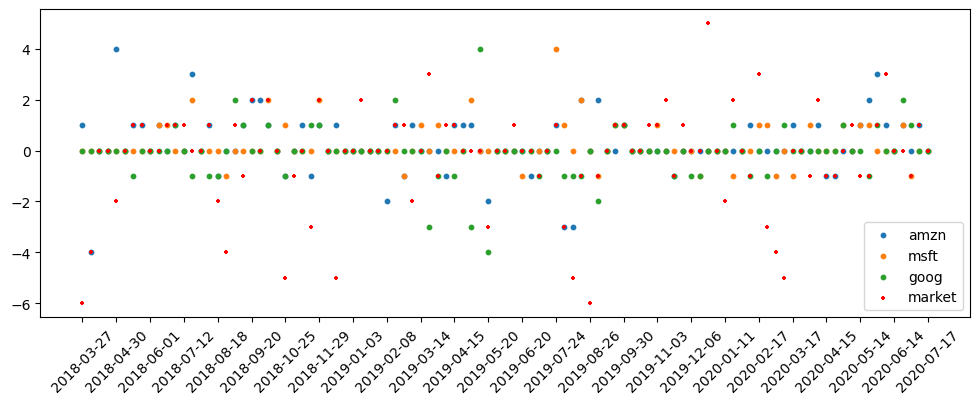

In [26]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(claude_responses.index, claude_responses['amzn'], label="amzn", s=10)
plt.scatter(claude_responses.index, claude_responses['msft'], label="msft", s=10)
plt.scatter(claude_responses.index, claude_responses['goog'], label="goog", s=10)
plt.scatter(claude_responses.index, claude_responses['market'], label="market", s=5, color="red", marker='+')
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
plt.legend()
plt.show()

<Axes: xlabel='Date'>

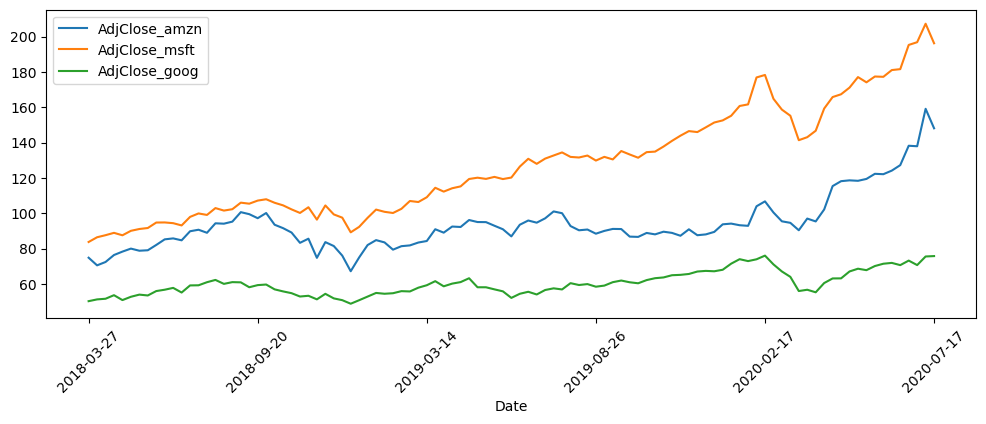

In [27]:
df[['AdjClose_amzn', 'AdjClose_msft', 'AdjClose_goog']].plot(figsize=(12,4), rot=45)

In [236]:
claude_responses[['amzn', 'msft', 'goog', 'market']].describe()

,amzn,msft,goog,market
count,101.00,101.00,101.00,101.00
mean,0.22,0.21,-0.07,-0.29
std,1.12,0.75,0.97,1.95
min,-4.00,-1.00,-4.00,-6.00
25%,0.00,0.00,0.00,-1.00
50%,0.00,0.00,0.00,0.00
75%,1.00,0.00,0.00,1.00
max,4.00,4.00,4.00,5.00


In [29]:
def evaluate_orders(orders):
    #initial cash
    initial_cash = 1000000
    
    book = \
    df[['Open_amzn', 'AdjClose_amzn', 'Open_msft', 'AdjClose_msft', 'Open_goog', 'AdjClose_goog']].copy(deep=True)
    
    book['o(a)'] = np.nan
    book['o(m)'] = np.nan
    book['o(g)'] = np.nan
    book['cash'] = 0.0
    book['u(a)'] = 0
    book['u(m)'] = 0
    book['u(g)'] = 0
    book['value'] = 0.0

    book.loc[book.index[0], 'cash'] = initial_cash
    book.loc[book.index[0], 'value'] = book.loc[book.index[0], 'cash'] \
        + book.loc[book.index[0], 'AdjClose_amzn'] * book.loc[book.index[0], 'u(a)'] \
        + book.loc[book.index[0], 'AdjClose_msft'] * book.loc[book.index[0], 'u(m)'] \
        + book.loc[book.index[0], 'AdjClose_goog'] * book.loc[book.index[0], 'u(g)']

    #insert orders
    book.loc[:, 'o(a)'] = orders['o(a)']
    book.loc[:, 'o(m)'] = orders['o(m)']
    book.loc[:, 'o(g)'] = orders['o(g)']

    #keep rasio for days without new orders
    book['o(a)'] = book['o(a)'].ffill()
    book['o(m)'] = book['o(m)'].ffill()
    book['o(g)'] = book['o(g)'].ffill()
    
    #calculate values
    order_date = book.index[0]
    #print(order_date)
    for date in book.index[1:]:
        #print(date)
        value = book.loc[order_date, 'cash']
        # for simple calculation, sell all at same price to buy then rebuy as order
        value += book.loc[order_date, 'u(a)'] * book.loc[date, 'Open_amzn']
        value += book.loc[order_date, 'u(m)'] * book.loc[date, 'Open_msft']
        value += book.loc[order_date, 'u(g)'] * book.loc[date, 'Open_goog']
        #print("value:" + str(value))
        cash = value
        # buy as order
        order = book.loc[order_date, 'o(a)']
        price = book.loc[date, 'Open_amzn']
        pay = value * order / 100
        book.loc[date, 'u(a)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"a o:{order} p:{price} pay:{pay} u(a): {book.loc[date, 'u(a)']} cash: {cash}")

        order = book.loc[order_date, 'o(m)']
        price = book.loc[date, 'Open_msft']
        pay = value * order / 100
        book.loc[date, 'u(m)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"m o:{order} p:{price} pay:{pay} u(m): {book.loc[date, 'u(m)']} cash: {cash}")

        order = book.loc[order_date, 'o(g)']
        price = book.loc[date, 'Open_goog']
        pay = value * order / 100
        book.loc[date, 'u(g)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"g o:{order} p:{price} pay:{pay} u(g): {book.loc[date, 'u(g)']} cash: {cash}")

        book.loc[date, 'cash'] = cash
        book.loc[date, 'value'] = book.loc[date, 'cash'] \
            + book.loc[date, 'u(a)'] * book.loc[date, 'AdjClose_amzn'] \
            + book.loc[date, 'u(m)'] * book.loc[date, 'AdjClose_msft'] \
            + book.loc[date, 'u(g)'] * book.loc[date, 'AdjClose_goog']
        #print(f"cash {cash} value {book.loc[date, 'value']}")
        # set order date for the next day
        order_date = date
    
    return book

In [30]:
'''
base line 1
'''

bl1_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])
bl1_order.loc[bl1_order.index[0], 'o(a)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(m)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(g)'] = 33.333333

In [31]:
bl1_book = evaluate_orders(bl1_order)

cash = bl1_book.iloc[1]['cash']
u_a = bl1_book.iloc[1]['u(a)']
u_m = bl1_book.iloc[1]['u(m)']
u_g = bl1_book.iloc[1]['u(g)']
for date in bl1_book.index[2:]:
    bl1_book.loc[date, 'o(a)'] = np.nan 
    bl1_book.loc[date, 'o(m)'] = np.nan 
    bl1_book.loc[date, 'o(g)'] = np.nan
    bl1_book.loc[date, 'cash'] = cash 
    bl1_book.loc[date, 'u(a)'] = u_a 
    bl1_book.loc[date, 'u(m)'] = u_m
    bl1_book.loc[date, 'u(g)'] = u_g
    bl1_book.loc[date, 'value'] = cash \
        + bl1_book.loc[date, 'AdjClose_amzn'] * bl1_book.loc[date, 'u(a)'] \
        + bl1_book.loc[date, 'AdjClose_msft'] * bl1_book.loc[date, 'u(m)'] \
        + bl1_book.loc[date, 'AdjClose_goog'] * bl1_book.loc[date, 'u(g)']

In [262]:
bl1_book.head(5)

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,33.33,33.33,33.33,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,33.33,33.33,33.33,95.93,4908,3794,6710,1018097.34
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,NaN,NaN,NaN,95.93,4908,3794,6710,1034317.40
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,NaN,NaN,NaN,95.93,4908,3794,6710,1072315.67
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,NaN,NaN,NaN,95.93,4908,3794,6710,1057877.79


In [32]:
'''
base line 2
'''
bl2_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])

bl2_order.loc[bl2_order.index[0], 'o(a)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(m)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(g)'] = 30.0

In [33]:
bl2_book = evaluate_orders(bl2_order)

In [264]:
bl2_book.head(5)

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,30.00,30.00,30.00,100152.63,4417,3414,6039,1016287.94
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,30.00,30.00,30.00,104488.72,4347,3385,6105,1031018.14
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,30.00,30.00,30.00,110058.11,4222,3436,6092,1064893.99
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,30.00,30.00,30.00,108955.58,4128,3391,6342,1051659.55


In [34]:
'''

my order

'''

'\n\nmy order\n\n'

In [265]:
orders = pd.DataFrame(data=claude_responses[['amzn', 'msft', 'goog', 'market']]).copy(deep=True)
orders['o(a)'] = 0.0
orders['o(m)'] = 0.0
orders['o(g)'] = 0.0

In [266]:
orders.loc[orders.index[0], 'o(a)'] = 30.0
orders.loc[orders.index[0], 'o(m)'] = 30.0
orders.loc[orders.index[0], 'o(g)'] = 30.0

In [287]:
# company factor
cf = 2
# market factor
mf = 0.05
yesterday = orders.index[0]
for date in orders.index[1:]:
    
    o_a = max(orders.loc[yesterday,'o(a)']+orders.loc[yesterday,'amzn']*cf+orders.loc[yesterday,'market']*mf, 0)
    o_m = max(orders.loc[yesterday,'o(m)']+orders.loc[yesterday,'msft']*cf+orders.loc[yesterday,'market']*mf, 0)
    o_g = max(orders.loc[yesterday,'o(g)']+orders.loc[yesterday,'goog']*cf+orders.loc[yesterday,'market']*mf, 0)
    
    #scale if sum > 100
    o_sum = o_a + o_m + o_g
    if ( o_sum > 100 ):
        o_a = o_a * 100 / o_sum
        o_m = o_m * 100 / o_sum
        o_g = o_g * 100 / o_sum
    
    orders.loc[date,'o(a)'] = o_a
    orders.loc[date,'o(m)'] = o_m
    orders.loc[date,'o(g)'] = o_g
    
    # for next look
    yesterday = date


In [288]:
orders

,amzn,msft,goog,market,o(a),o(m),o(g)
Date,,,,,,,
2018-03-27,1,0,0,-6,30.00,30.00,30.00
2018-04-04,-4,0,0,-4,31.70,29.70,29.70
2018-04-12,0,0,0,0,23.50,29.50,29.50
2018-04-22,0,0,0,0,23.50,29.50,29.50
2018-04-30,4,0,0,-2,23.50,29.50,29.50
...,...,...,...,...,...,...,...
2020-06-14,0,0,0,0,45.48,51.05,3.47
2020-06-23,1,1,2,0,45.48,51.05,3.47
2020-06-30,0,-1,1,-1,43.96,49.12,6.92


<Axes: xlabel='Date'>

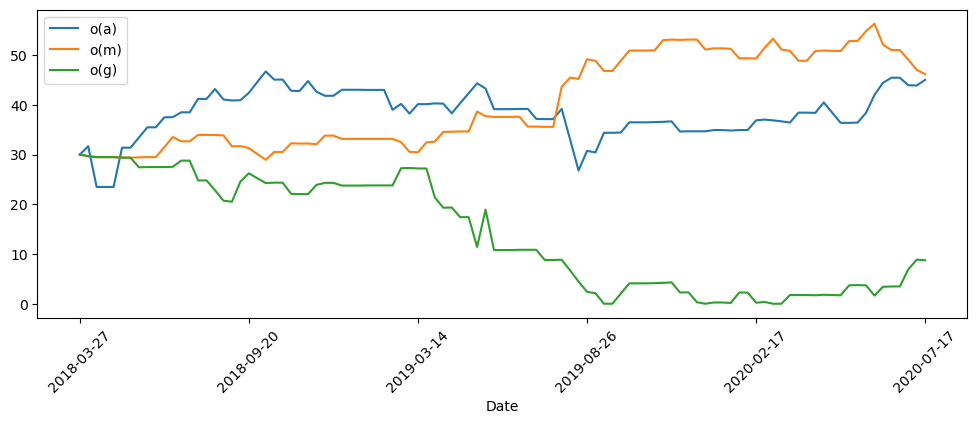

In [289]:
orders[['o(a)', 'o(m)', 'o(g)']].plot(figsize=(12,4), rot=45)

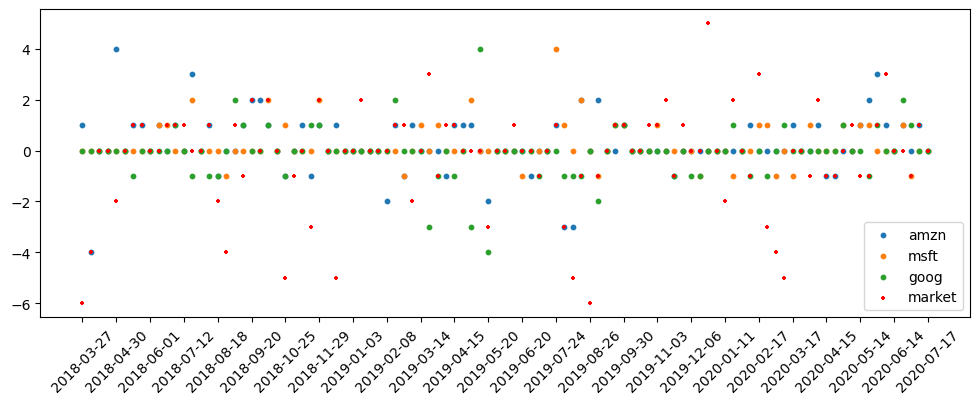

In [290]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(claude_responses.index, claude_responses['amzn'], label="amzn", s=10)
plt.scatter(claude_responses.index, claude_responses['msft'], label="msft", s=10)
plt.scatter(claude_responses.index, claude_responses['goog'], label="goog", s=10)
plt.scatter(claude_responses.index, claude_responses['market'], label="market", s=5, color="red", marker='+')
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
plt.legend()
plt.show()

In [291]:
my_order = orders
my_book = evaluate_orders(my_order)

In [292]:
my_book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,31.70,29.70,29.70,100152.63,4417,3414,6039,1016287.94
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,23.50,29.50,29.50,92979.88,4594,3351,6044,1031270.75
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,23.50,29.50,29.50,192604.44,3311,3383,5997,1068053.38
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,23.50,29.50,29.50,190778.66,3235,3335,6239,1053413.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14,130.06,127.25,190.54,181.58,71.42,70.66,45.48,51.05,3.47,170.86,6265,5017,875,1770196.71
2020-06-23,136.30,138.22,202.09,195.28,72.78,73.22,45.48,51.05,3.47,104.35,6445,4879,922,1911224.78
2020-06-30,134.25,137.94,197.88,196.83,69.52,70.68,43.96,49.12,6.92,145.49,6419,4888,946,1914554.25


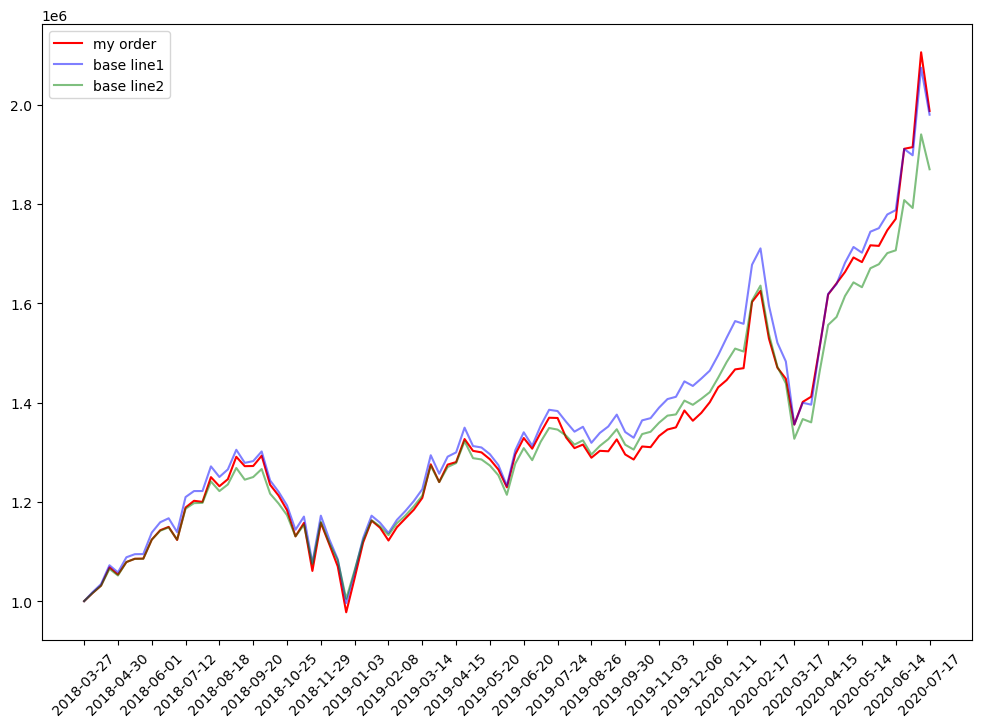

In [293]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(my_book.index, my_book['value'], label = "my order", color='red', alpha=1.0)
plt.plot(bl1_book.index, bl1_book['value'], label = "base line1", color='blue', alpha=0.5)
plt.plot(bl2_book.index, bl2_book['value'], label = "base line2", color='green', alpha=0.5)
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
plt.legend() 
plt.show()

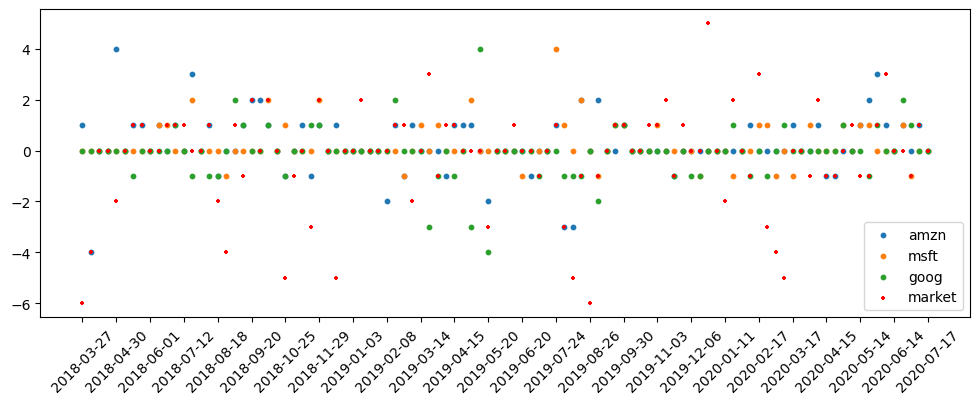

In [294]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(claude_responses.index, claude_responses['amzn'], label="amzn", s=10)
plt.scatter(claude_responses.index, claude_responses['msft'], label="msft", s=10)
plt.scatter(claude_responses.index, claude_responses['goog'], label="goog", s=10)
plt.scatter(claude_responses.index, claude_responses['market'], label="market", s=5, color="red", marker='+')
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
plt.legend()
plt.show()

In [295]:
bl1_gain = bl1_book['value'].iloc[-1]/bl1_book['value'].iloc[0]
bl2_gain = bl2_book['value'].iloc[-1]/bl2_book['value'].iloc[0]
your_gain = my_book['value'].iloc[-1]/my_book['value'].iloc[0]
print(f"your gain: {your_gain}")
print(f"base line1 gain: {bl1_gain} yourgain/bl1 ratio: {your_gain/bl1_gain}")
print(f"base line2 gain: {bl2_gain} yourgain/bl2 ratio {your_gain/bl2_gain}")

your gain: 1.9874473074759997
base line1 gain: 1.979888910038 yourgain/bl1 ratio: 1.003817586633108
base line2 gain: 1.869972633553999 yourgain/bl2 ratio 1.0628216006021076


<Axes: xlabel='Date'>

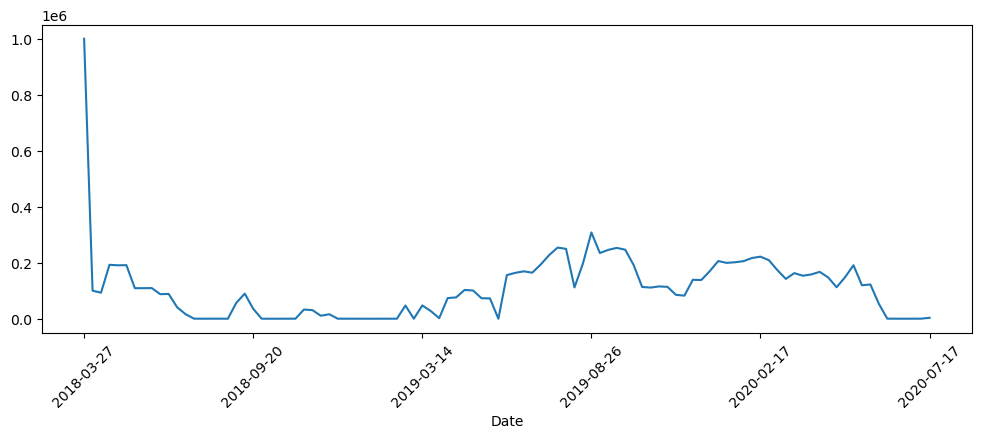

In [296]:
my_book['cash'].plot(figsize=(12,4), rot=45)